In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_azure = pd.read_csv("/kaggle/input/azure-d/azure.csv")
print(df_azure.columns)
df_azure.shape

Index(['timestamp', 'min cpu', 'max cpu', 'avg cpu'], dtype='object')


(8640, 4)

In [3]:
df_azure['timestamp'] = pd.to_datetime(df_azure['timestamp'])
df_azure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  8640 non-null   datetime64[ns]
 1   min cpu    8640 non-null   float64       
 2   max cpu    8640 non-null   float64       
 3   avg cpu    8640 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 270.1 KB


In [4]:
df_azure

,timestamp,min cpu,max cpu,avg cpu
0,2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
1,2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2,2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
3,2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
4,2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06
...,...,...,...,...
8635,2017-01-30 23:35:00,728008.315162,2.233166e+06,1.242129e+06
8636,2017-01-30 23:40:00,737452.951022,2.219408e+06,1.235937e+06
8637,2017-01-30 23:45:00,742153.686192,2.188120e+06,1.224276e+06
8638,2017-01-30 23:50:00,725404.574579,2.156483e+06,1.201533e+06


In [5]:
df = df_azure.copy()
df = df[["timestamp","avg cpu"]]
df

,timestamp,avg cpu
0,2017-01-01 00:00:00,1.229569e+06
1,2017-01-01 00:05:00,1.211322e+06
2,2017-01-01 00:10:00,1.206635e+06
3,2017-01-01 00:15:00,1.190369e+06
4,2017-01-01 00:20:00,1.180992e+06
...,...,...
8635,2017-01-30 23:35:00,1.242129e+06
8636,2017-01-30 23:40:00,1.235937e+06
8637,2017-01-30 23:45:00,1.224276e+06
8638,2017-01-30 23:50:00,1.201533e+06


In [6]:
data = df.filter(['avg cpu'])
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

6912

In [7]:
train_data = df.iloc[0:int(training_data_len), :]
test_data = df.iloc[training_data_len - 60: , :]

In [8]:
def create_sequences_lstm_2(data, seq_length=12):
    xs = []
    ys = []
    indices = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0:1]  # Select only the feature columns
        y = data[i+seq_length, 0]  # Select the target value
        xs.append(x)
        ys.append(y)
        indices.append(data[i+seq_length, 1])  # Capture the timestamp for plotting
    return np.array(xs), np.array(ys), np.array(indices)

In [9]:
train_data = train_data[['avg cpu', 'timestamp']].to_numpy()
test_data = test_data[['avg cpu', 'timestamp']].to_numpy()

In [10]:
train_data.shape,test_data.shape

((6912, 2), (1788, 2))

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[:, 0] = scaler.fit_transform(train_data[:, 0].reshape(-1, 1)).flatten()
test_data[:, 0] = scaler.transform(test_data[:, 0].reshape(-1, 1)).flatten()    

In [13]:
X_train, y_train,indices_train  = create_sequences_lstm_2(train_data)
X_test, y_test,indices_test = create_sequences_lstm_2(test_data)

In [14]:
y_train = np.array([np.array([item]) for item in y_train])

In [15]:
y_test = np.array([np.array([item]) for item in y_test])

In [16]:
train_indices = pd.to_datetime(indices_train)
test_indices = pd.to_datetime(indices_test)

In [17]:
X_train[0],y_train[0]

(array([[0.29762310546498805],
        [0.2759800410560376],
        [0.27042115919930554],
        [0.2511280089037595],
        [0.24000641455688387],
        [0.2866158535762102],
        [0.25366547015095864],
        [0.22031577354098641],
        [0.21897754141797],
        [0.22023757647777553],
        [0.22274266020493916],
        [0.25139359795288807]], dtype=object),
 array([0.22844245]))

In [18]:
X_test[0],y_test[0]

(array([[0.41748757075237264],
        [0.3963954714763511],
        [0.4289235045402813],
        [0.47080224123054015],
        [0.4702853950827681],
        [0.4609194755444912],
        [0.42102914469466257],
        [0.4187044900629928],
        [0.4444025323177121],
        [0.4203968229595163],
        [0.39944886680117175],
        [0.4014469790535695]], dtype=object),
 array([0.38554465]))

In [19]:
indices_train[-1],indices_test[-1]

(Timestamp('2017-01-24 23:50:00'), Timestamp('2017-01-30 23:50:00'))

In [20]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional

# Initialize the model
model = Sequential()

# Add Bi-GRU layers with more units and add dropout for regularization
model.add(Bidirectional(GRU(256, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(Bidirectional(GRU(64, return_sequences=False)))
model.add(Dropout(0.2))  # Dropout for regularization

# Add more dense layers
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


2024-04-16 16:15:59.549067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 16:15:59.549242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 16:15:59.703442: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6899, 12, 1)
X_test shape: (1775, 12, 1)


In [22]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [23]:
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(X_test))
assert not np.any(np.isnan(y_train))
assert not np.any(np.isnan(y_test))

In [24]:
# history = model.fit(X_train, y_train, batch_size=16, epochs=100,validation_data=(X_test,y_test))
# history

In [25]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss Progress During Training')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()


In [26]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Predicting and inverse transform to original scale
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)
# y_train_pred = scaler.inverse_transform(y_train_pred)
# y_test_pred = scaler.inverse_transform(y_test_pred)
# y_train = scaler.inverse_transform(y_train.reshape(-1,1))
# y_test = scaler.inverse_transform(y_test.reshape(-1,1))

# # Calculate performance metrics
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)
# train_mae = mean_absolute_error(y_train, y_train_pred)
# train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)
# test_mae = mean_absolute_error(y_test, y_test_pred)
# test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# print('Train MSE:', train_mse)
# print('Train RMSE:', train_rmse)
# print('Train MAE:', train_mae)
# print('Train MAPE:', train_mape)

# print('Test MSE:', test_mse)
# print('Test RMSE:', test_rmse)
# print('Test MAE:', test_mae)
# print('Test MAPE:', test_mape)


In [27]:
# import matplotlib.pyplot as plt

# # Ensure indices are in datetime format for plotting
# train_indices = pd.to_datetime(train_indices)
# test_indices = pd.to_datetime(test_indices)

# # Plot training data
# plt.figure(figsize=(15,7))
# plt.plot(train_indices, y_train.flatten(), label='Actual Train', color='blue')
# plt.plot(train_indices, y_train_pred.flatten(), label='Predicted Train', color='orange')
# plt.title('Train Prediction')
# plt.xlabel('Time')
# plt.ylabel('Average CPU Usage')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot testing data
# plt.figure(figsize=(15,7))
# plt.plot(test_indices, y_test.flatten(), label='Actual Test', color='blue')
# plt.plot(test_indices, y_test_pred.flatten(), label='Predicted Test', color='orange')
# plt.title('Test Prediction')
# plt.xlabel('Time')
# plt.ylabel('Average CPU Usage')
# plt.legend()
# plt.grid(True)
# plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from keras.optimizers import Adam

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(1))
    return model

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(Dense(1))
    return model

# Define Bi-LSTM model
def create_bi_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(Dense(1))
    return model

# Define GRU model
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16))
    model.add(Dense(1))
    return model



In [29]:
# Compile model
def compile_model(model):
    model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train model
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
    return history

# Plot training and validation loss
def plot_loss(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


input_shape=(X_train.shape[1], 1)
# Create and train LSTM model



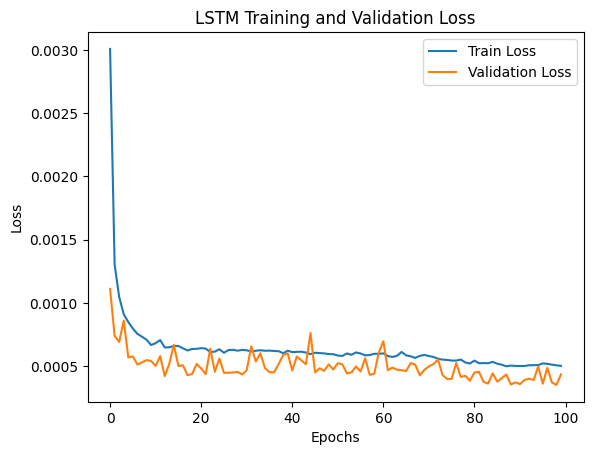

In [30]:
lstm_model = create_lstm_model(input_shape)
compile_model(lstm_model)
lstm_history = train_model(lstm_model, X_train, y_train, X_test, y_test)
plot_loss(lstm_history, 'LSTM')

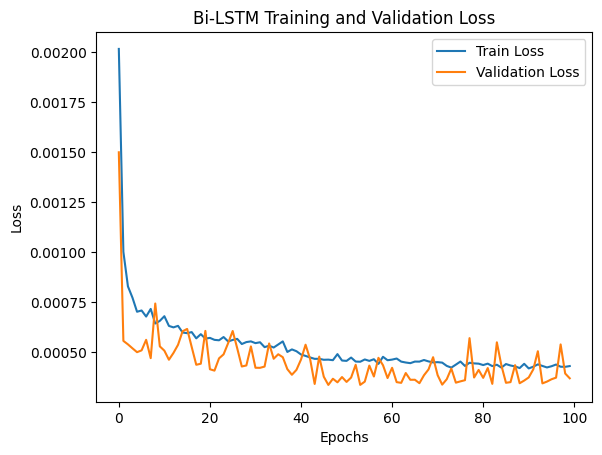

In [31]:
# Create and train Bi-LSTM model
bi_lstm_model = create_bi_lstm_model(input_shape)
compile_model(bi_lstm_model)
bi_lstm_history = train_model(bi_lstm_model, X_train, y_train, X_test, y_test)
plot_loss(bi_lstm_history, 'Bi-LSTM')

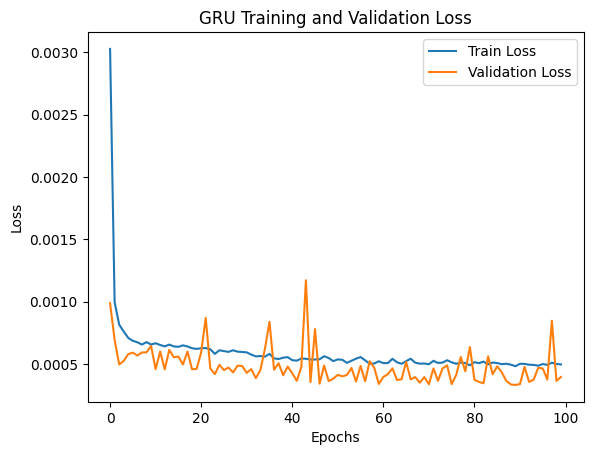

In [32]:
# Create and train GRU model
gru_model = create_gru_model(input_shape)
compile_model(gru_model)
gru_history = train_model(gru_model, X_train, y_train, X_test, y_test)
plot_loss(gru_history, 'GRU')


In [33]:
# Save the models
lstm_model.save("lstm_model110.h5")


In [34]:
gru_model.save("gru_model1.h5")

In [35]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# # Load saved models
# lstm_model = load_model("path_to_lstm_model.h5")
# bi_lstm_model = load_model("path_to_bi_lstm_model.h5")
# gru_model = load_model("path_to_gru_model.h5")



# Evaluate LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

# Evaluate Bi-LSTM model
bi_lstm_predictions = bi_lstm_model.predict(X_test)
bi_lstm_mse = mean_squared_error(y_test, bi_lstm_predictions)
bi_lstm_mae = mean_absolute_error(y_test, bi_lstm_predictions)
bi_lstm_r2 = r2_score(y_test, bi_lstm_predictions)

# Evaluate GRU model
gru_predictions = gru_model.predict(X_test)
gru_mse = mean_squared_error(y_test, gru_predictions)
gru_mae = mean_absolute_error(y_test, gru_predictions)
gru_r2 = r2_score(y_test, gru_predictions)

# Print evaluation results
print("LSTM Model:")
print("Mean Squared Error:", lstm_mse)
print("Mean Absolute Error:", lstm_mae)
print("R-squared Score:", lstm_r2)
print()

print("Bi-LSTM Model:")
print("Mean Squared Error:", bi_lstm_mse)
print("Mean Absolute Error:", bi_lstm_mae)
print("R-squared Score:", bi_lstm_r2)
print()

print("GRU Model:")
print("Mean Squared Error:", gru_mse)
print("Mean Absolute Error:", gru_mae)
print("R-squared Score:", gru_r2)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
LSTM Model:
Mean Squared Error: 0.000435244
Mean Absolute Error: 0.015222299
R-squared Score: 0.9744297539671327

Bi-LSTM Model:
Mean Squared Error: 0.00037119896
Mean Absolute Error: 0.014751758
R-squared Score: 0.9781923489796653

GRU Model:
Mean Squared Error: 0.00039624912
Mean Absolute Error: 0.014480086
R-squared Score: 0.9767206709634279


Based on the provided metrics, the LSTM Model has the lowest Mean Squared Error (MSE) and Mean Absolute Error (MAE), and the highest R-squared Score. Therefore, the LSTM Model appears to be performing the best among the three models.